# Electricity prices in Poland - forecasting project

In this notebook I will analysie historical daily electricity prices in Poland and build forecasting model. This year we have experienced one of the highest electricity prices ever mainly due to the inflation combined with Russian-Ukraine war. Based on the daily data I am going to build model which would accurately predict the future prices. I will use MAPE (mean absolute percentage error) as a measurement of model performance.

### DATA

I have downloaded the data from https://energy.instrat.pl/energy_prices, data contains Day-Ahead energy contract prices in Poland in Polish Zloty (PLN) per Megawatt Hour (MWh) and the volume in MWh since 2016.


In [754]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cleaning and pre-processing

In [755]:
df = pd.read_csv('tge_rdn_indexes.csv',parse_dates=['index'])
df

,index,indeks,Price [PLN/MWh],Volume [MWh]
0,2016-01-02,TGe24,118.78,57856.9
1,2016-01-02,TGeBase,120.60,83955.2
2,2016-01-03,TGe24,122.09,49260.5
3,2016-01-03,TGeBase,122.62,82050.9
4,2016-01-04,TGe24,145.21,47974.1
...,...,...,...,...
9947,2022-11-13,TGePeak,837.36,56267.9
9948,2022-11-13,TGeOffpeak,608.42,27495.5
9949,2022-11-13,TGe24,749.99,70262.8
9950,2022-11-13,TGe15,837.36,46630.9


I will be using only TGeBase index in my forecasting models.

In [756]:
df = df[df['indeks'] == 'TGeBase']
df

,index,indeks,Price [PLN/MWh],Volume [MWh]
1,2016-01-02,TGeBase,120.60,83955.2
3,2016-01-03,TGeBase,122.62,82050.9
5,2016-01-04,TGeBase,141.03,66314.9
7,2016-01-05,TGeBase,173.67,77522.8
9,2016-01-06,TGeBase,152.27,75863.9
...,...,...,...,...
9922,2022-11-09,TGeBase,619.05,72113.3
9928,2022-11-10,TGeBase,666.36,77057.8
9934,2022-11-11,TGeBase,714.85,75398.6
9940,2022-11-12,TGeBase,599.00,77752.0


In [757]:
df.shape

(2508, 4)

In [758]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2508 entries, 1 to 9946
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            2508 non-null   datetime64[ns]
 1   indeks           2508 non-null   object        
 2   Price [PLN/MWh]  2508 non-null   float64       
 3   Volume [MWh]     2508 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 98.0+ KB


In [759]:
df.describe()

,Price [PLN/MWh],Volume [MWh]
count,2508.000000,2508.000000
mean,298.798270,82580.744896
std,238.916938,15198.457089
min,81.210000,45661.800000
25%,166.235000,71778.300000
50%,220.760000,81594.550000
75%,292.572500,92385.200000
max,1953.450000,151545.800000


As we can see above we do not have any NaN values in the dataset. 

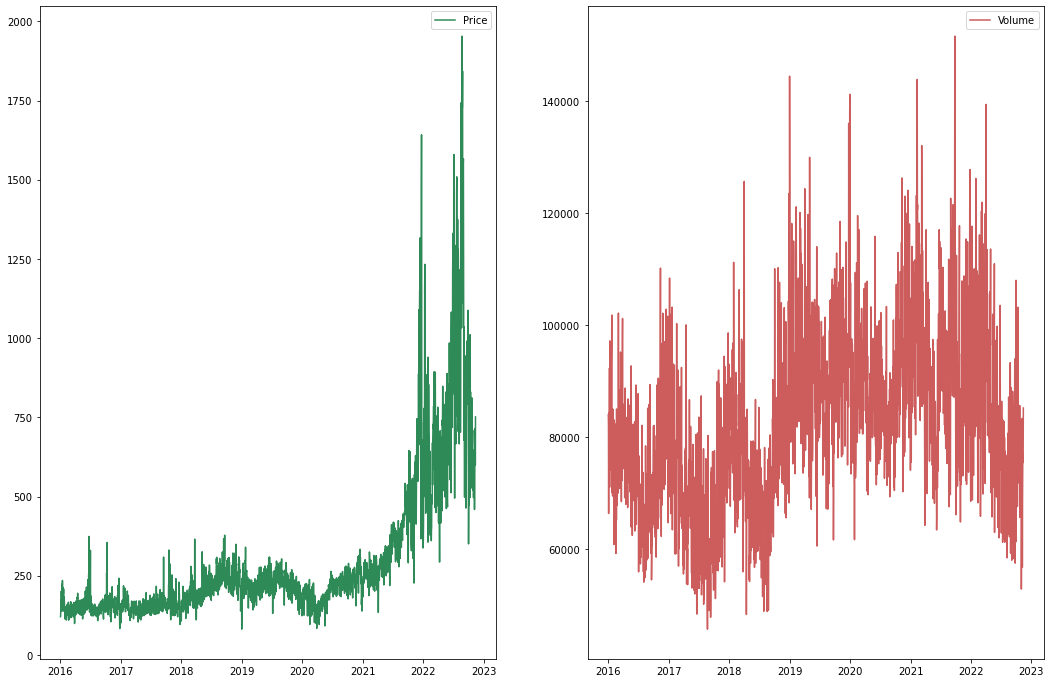

In [760]:
fig,ax = plt.subplots(1,2,figsize=(18,12))
ax = ax.flatten()
ax[0].plot(df['index'],df['Price [PLN/MWh]'], label='Price',color='seagreen')
ax[0].legend()
ax[1].plot(df['index'],df['Volume [MWh]'], label='Volume',color='indianred')
ax[1].legend()

plt.show()

After looking at the plots above we can notice some cyclic patterns in our data.

In [761]:
df_s = df[:800]
df_monthly = df[500:800]
df_weekly = df[500:533]


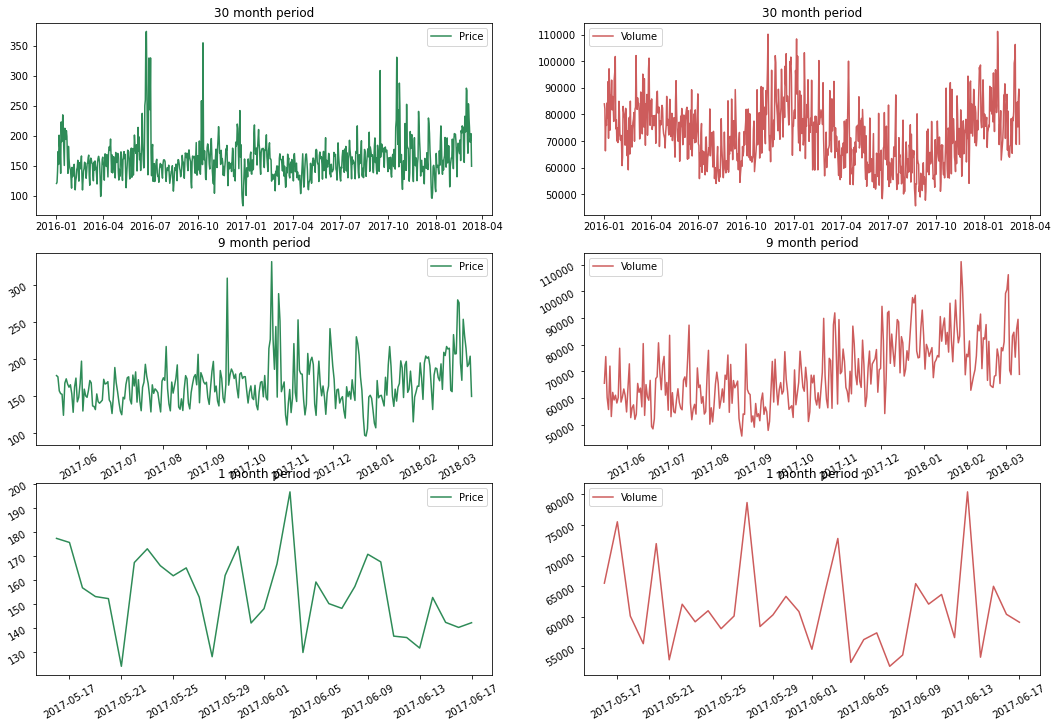

In [762]:
fig,ax = plt.subplots(3,2,figsize=(18,12))
ax = ax.flatten()
ax[0].plot(df_s['index'],df_s['Price [PLN/MWh]'], label='Price',color='seagreen')
ax[0].title.set_text('30 month period')
ax[0].legend()
ax[1].plot(df_s['index'],df_s['Volume [MWh]'], label='Volume',color='indianred')
ax[1].title.set_text('30 month period')
ax[1].legend()
ax[2].plot(df_monthly['index'],df_monthly['Price [PLN/MWh]'], label='Price',color='seagreen')
ax[2].tick_params(labelrotation=30)
ax[2].title.set_text('9 month period')
ax[2].legend()
ax[3].plot(df_monthly['index'],df_monthly['Volume [MWh]'], label='Volume',color='indianred')
ax[3].tick_params(labelrotation=30)
ax[3].title.set_text('9 month period')
ax[3].legend()
ax[4].plot(df_weekly['index'],df_weekly['Price [PLN/MWh]'], label='Price',color='seagreen')
ax[4].tick_params(labelrotation=30)
ax[4].title.set_text('1 month period')
ax[4].legend()
ax[5].plot(df_weekly['index'],df_weekly['Volume [MWh]'], label='Volume',color='indianred')
ax[5].tick_params(labelrotation=30)
ax[5].title.set_text('1 month period')
ax[5].legend()

plt.show()

I have decided to plot price and volume of electricity for shorted periods in order to investigate the cyclic patterns in the data. I have noticed that the volume shows more repetive patterns than price. However in this analysis we will focus on the price data.

In [763]:
df.rename(columns={'Price [PLN/MWh]': 'Price','Volume [MWh]': 'Volume','index':'Date'},inplace=True)
df.drop(columns=['indeks'],inplace=True)

C:\Users\Tymoteusz\AppData\Local\Temp\ipykernel_6536\3146931971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Price [PLN/MWh]': 'Price','Volume [MWh]': 'Volume','index':'Date'},inplace=True)
C:\Users\Tymoteusz\AppData\Local\Temp\ipykernel_6536\3146931971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['indeks'],inplace=True)


In [764]:
model_scores = pd.DataFrame(columns=['model','mape_test','mape_total','rmse_test','rmse_total'])
# This dataframe will help us evaluate and compare each model mape score

In [765]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

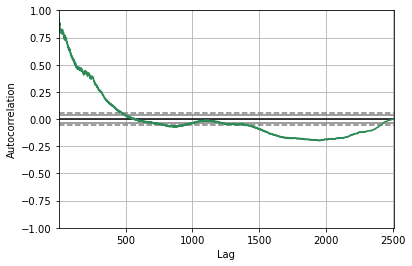

In [766]:
autocorrelation_plot(df['Price'],color='seagreen')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

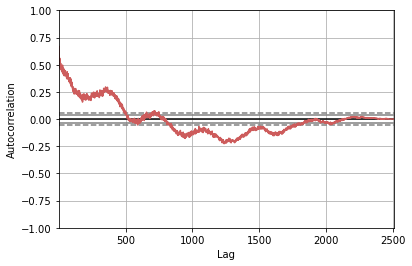

In [767]:
autocorrelation_plot(df['Volume'],color='indianred')

In [768]:
adfuller_price = adfuller(df['Price'])
adfuller_volume = adfuller(df['Volume'])
print('Adfuller - price',adfuller_price[0],adfuller_price[1])
print('Adfuller - volume',adfuller_volume[0],adfuller_volume[1])

Adfuller - price -1.1967656860309221 0.6749854822865725
Adfuller - volume -2.8388136068534604 0.05293983619552216


The above information helps us determine if differentiation will be needed in order to achieve stationary time-series. 0.67 p-value of adfuller test results indicates that the time-series is not stationary and differentiation will be neccessary in order to achieve stationary time-series.

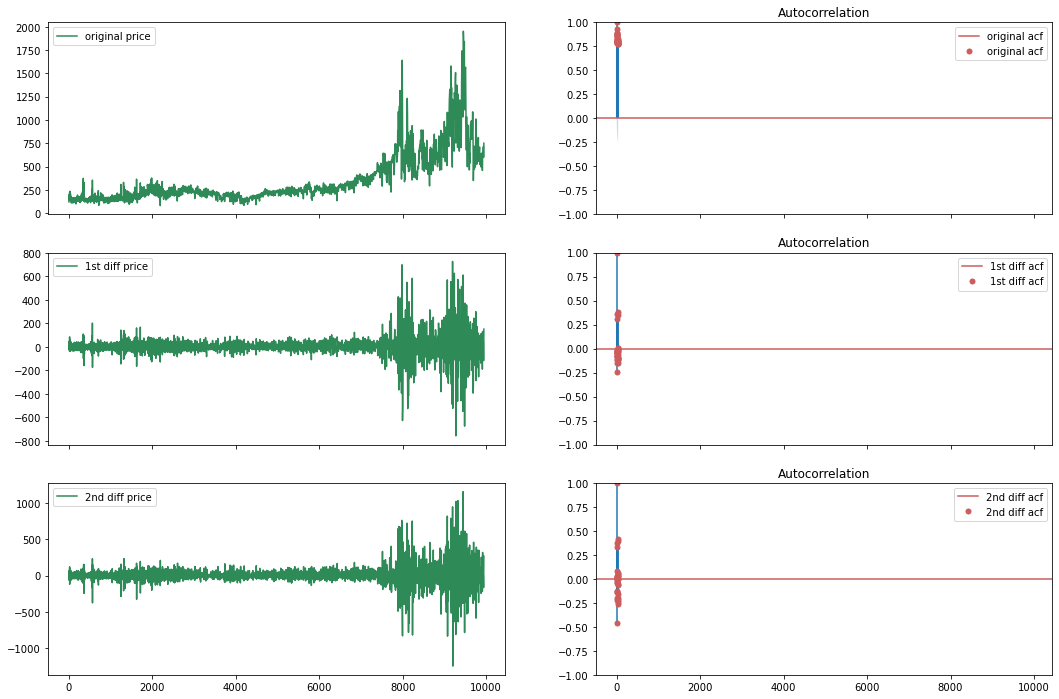

In [769]:
fig, ax = plt.subplots(3, 2, sharex=True,figsize=(18,12))
ax = ax.flatten()
ax[0].plot(df['Price'],label='original price',color='seagreen')
ax[0].legend()
plot_acf(df['Price'],label='original acf',ax=ax[1],color='indianred')
ax[1].legend()
ax[2].plot(df['Price'].diff(),label='1st diff price',color='seagreen')
ax[2].legend()
plot_acf(df['Price'].diff().dropna(),label='1st diff acf',ax=ax[3],color='indianred')
ax[3].legend()
ax[4].plot(df['Price'].diff().diff(),label='2nd diff price',color='seagreen')
ax[4].legend()
plot_acf(df['Price'].diff().diff().dropna(),label='2nd diff acf',ax=ax[5],color='indianred')
ax[5].legend()


The above plots contain information about the electricity price and its autocorrelation after 1st and 2nd differentiation. I think differentiating the price only once will be enough to obtain almost stationary time-series as the autocorrelation plot after 2nd differentiation suggest that the data might have been overdifferentiated.

C:\Users\Tymoteusz\AppData\Local\Temp\ipykernel_6536\2231481433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec.drop(columns=['Date'],inplace=True)


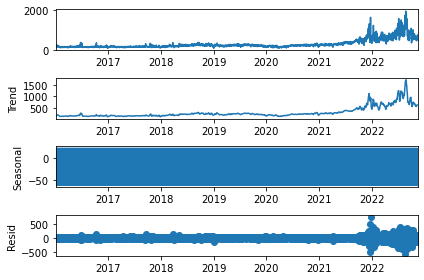

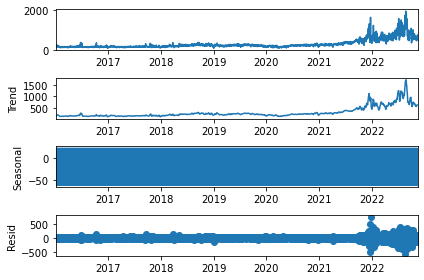

In [770]:
df_dec = df[['Date','Price']]
df_dec.index = df_dec['Date']
df_dec.drop(columns=['Date'],inplace=True)

stats_a = seasonal_decompose(df_dec,model='additive')
stats_m = seasonal_decompose(df_dec,model='multiplicative')
stats_a.plot()

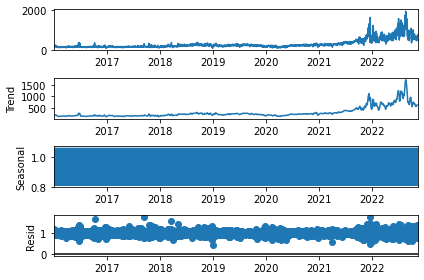

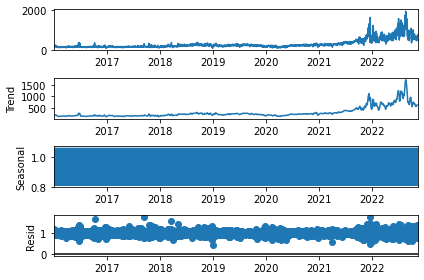

In [771]:
stats_m.plot()

The price of the electricity does not show significant seasonality so we will not use SARIMA model in our forecasting efforts.

In [772]:
import pmdarima as pm
df_arima = df[2100:]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4376.331, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4370.881, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4359.669, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4374.506, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4319.854, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4317.583, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4347.465, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4318.332, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4313.316, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4316.476, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=4303.401, Time=0.46 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, T

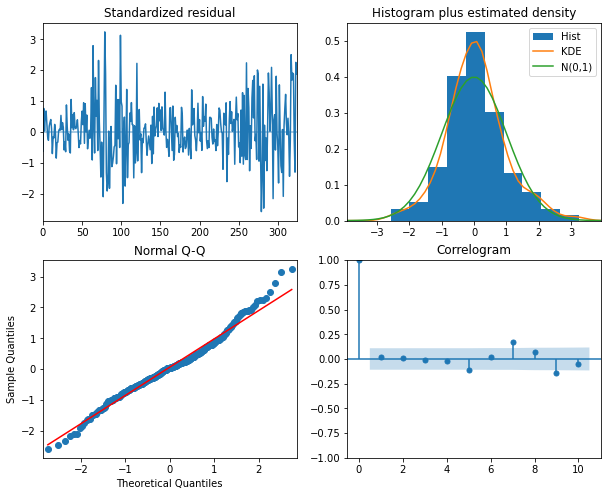

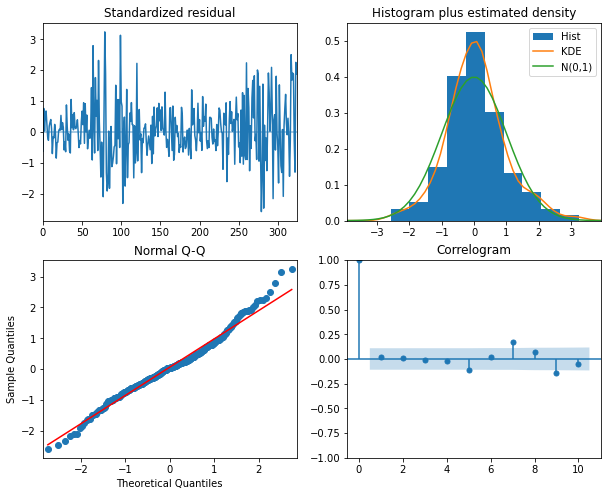

In [773]:
data_prices = df_arima['Price']
data_prices = data_prices.diff().dropna()
def train_test_splitter(data, test_ratio):
    train,test = data[:(int(len(data) * (1 - test_ratio)))], data[(int(len(data) * (1 - test_ratio))):]
    return train, test
train_a, test_a = train_test_splitter(data_prices, 0.2)
hist = [i for i in train_a]
pred_arima = []

arima_model = pm.auto_arima(hist,start_p=0,start_q=0,m=1,test='adf',max_p=10,max_q=10,d=None,stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
arima_model.plot_diagnostics(figsize=(10,8))
    

 For the ARIMA model I have decided to use observations from the last 408 days.

In [776]:
def auto_arima_test():
    for i in len(test_a):
        model = auto_arima(hist,start_p=0,start_q=0,m=1,test='adf',max_p=10,max_q=10,d=None,stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
        pred = model.forecast()
        a = pred[0]
        observation = test_a[i]
        history.append(observation)
        pred_arima.append(a)
    mape_t = mean_absolute_squared_error(test_a,pred_arima)
    rmse_t = np.sqrt(mean_squared_error(test_a, pred_arima))
    print(mape_t)
    print(rmse_t)
    return mape_t, rmse_t
mape_t, rmse_t auto_arima_test()
model_scores = model_scores.append({'model': 'ARIMA', 'mape test': 'mape_t','rmse test': 'rmse_t', 'mape total': 'NaN', 'rmse total': 'NaN'},ignore_index=True)
        

C:\Users\Tymoteusz\AppData\Local\Temp\ipykernel_6536\439324690.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'model': 'ARIMA', 'mape test': 'mape_t','rmse test': 'rmse_t', 'mape total': 'NaN', 'rmse total': 'NaN'},ignore_index=True)


### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# splitt method prep

time_split = TimeSeriesSplit(n_splits=5)

